<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/shuby-dev/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize
import random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms.functional as TF
import pandas as pd

%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
cuda


## Loading Data

In [2]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
    validation_size = training_data.shape[0]//10
    validation_data = training_data[0:validation_size]
    training_data = training_data[validation_size:]
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
    validation_size = training_labels.shape[0]//10
    validation_labels = training_labels[0:validation_size]
    training_labels = training_labels[validation_size:]
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

In [3]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1, l2 = int(label[0]), mapping[label[1].int()]
    readables.append((l1,l2,))
  return readables

In [4]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])    
    # plt.colorbar()
    plt.show()

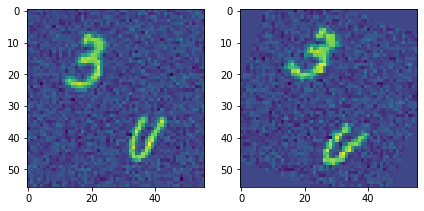

In [5]:
def generate_rotation(image_tensor, rotate_angles=[-20,20]):
    outputs = []
    for angle in rotate_angles:
      outputs.append(TF.rotate(image_tensor, angle))
    return outputs

sample_tensor = torch.from_numpy(training_data[0,None]).float()
rotated_tensor = generate_rotation(sample_tensor)[0]
img_grid(1,2,[sample_tensor[0],rotated_tensor[0]])

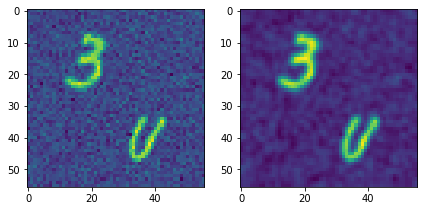

In [6]:
def generate_blur(image_tensor, blur_kernal = [1]):
  outputs = []
  for k in blur_kernal:
    outputs.append(TF.gaussian_blur(image_tensor, [k,k]))
  return outputs

sample_tensor = torch.from_numpy(training_data[0,None]).float()
sharp_tensor = generate_blur(sample_tensor,[3])[0]
img_grid(1,2,[sample_tensor[0],sharp_tensor[0]])

In [7]:
# transform all data to the output format
def process_training_data(data, labels, rotate_angles = [-30,-15,15,30], blur_kernal = [3]):
  multiplier = (1+len(rotate_angles)+len(blur_kernal))
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,0:10]))
    letter_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,10:]))
    # Creating the rotation and sharpness images
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_rotation(norm_img, rotate_angles):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_blur(norm_img, blur_kernal):
      new_data[output_index] = s_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset
  

In [27]:
def process_testing_data(data):
  data_tensor = torch.from_numpy(data[:,None]).float()
  dataset = torch.empty((len(data),1,56,56))
  for i in tqdm(range(len(data_tensor))):
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    dataset[i] = norm_img
  return dataset
testing_dataset = process_testing_data(testing_data)

100%|██████████| 15000/15000 [00:02<00:00, 6227.87it/s]


### Processing The Data

Process the data and put the data into dataloader

In [10]:
def make_data_loader(dataset, batch_size=30, shuffle=True, num_workers=2):
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return dataloader

training_dataset = process_training_data(training_data, training_labels)
validation_dataset = process_training_data(validation_data,validation_labels, [], [])

training_loader = make_data_loader(training_dataset)
validation_loader = make_data_loader(validation_dataset)

100%|██████████| 15000/15000 [00:02<00:00, 6840.78it/s]


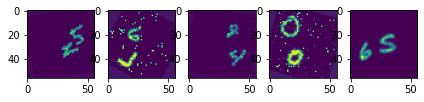

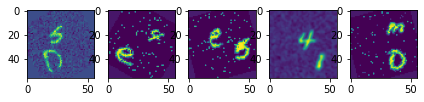

[(5, 'z'), (6, 'j'), (4, 'q'), (0, 'o'), (6, 's'), (0, 's'), (4, 'e'), (5, 'e'), (4, 'i'), (0, 'm')]


In [12]:
def show_sample(n):
  perm = torch.randperm(len(training_dataset))
  idx = perm[:n]
  data, labels = training_dataset[idx]
  img_grid(n//5,5 , data[:,0])
  print(convert_labels_to_readables(labels))
show_sample(10)

## Training Model

### Multi-Output Model

Initalize the Multilabel Model

In [13]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 4 convolution layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3 Dense Layer
        self.fc11 = nn.Linear(256*3*3, 1000)
        self.fc12 = nn.Linear(256*3*3, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(100, 10)
        self.fc32 = nn.Linear(1000, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        l1 = F.relu(self.fc21(F.relu(self.fc11(x))))
        l2 = F.relu(self.fc22(F.relu(self.fc12(x))))
        l1 = self.fc31(l1)
        l2 = self.fc32(l2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output




In [96]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class CustomResNet(nn.Module):

    def __init__(self, norm_layer = None, groups = 1, width_per_group = 64):
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        super(CustomResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.layer1 = self._make_layer(models.resnet.BasicBlock, 64, 2)
        self.layer2 = self._make_layer(models.resnet.BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(models.resnet.BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(models.resnet.BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc1 = nn.Linear(2048, 10)
        self.fc2 = nn.Linear(2048, 26)
      
    def _make_layer(self, block, planes, blocks, stride = 1, dilate = False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, planes,groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        l1 = self.fc1(x)
        l2 = self.fc2(x)
        return l1,l2


### Training and Validation

Initialize network validation and training function

In [14]:
def validate_model(model):
  digit_acc, letter_acc = 0, 0
  print("Starting Validation Iteration")
  for i, validation_data in enumerate(tqdm(validation_loader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_loader)
  letter_acc = letter_acc / len(validation_loader)
  print(f'\n Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')
  return (digit_acc.item(), letter_acc.item())

In [15]:
def train_network(net, optimizer, criterion, max_epoch = 10, last_index = len(training_loader), do_validation = True):
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      print("Starting Training Iteration")
      for i, data in enumerate(tqdm(training_loader)):
          if epoch == max_epoch - 1 and i > last_index:
            break
          
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
          if i % 100 == 99:
            print('[%d] loss: %.3f' % (i // 100, running_loss / cnt))
            running_loss, cnt = 0.0, 0
      if do_validation:
        digit_acc, letter_acc = validate_model(net)
        digits_accs.append(digit_acc)
        letter_accs.append(letter_acc)
        return (digits_accs, letter_accs)

In [16]:
def train_model(net, optimizer, do_validation = True, epoch = 1, last_index = len(training_loader)):
  multi_net_criterion = nn.CrossEntropyLoss()
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  if do_validation:
    res = train_network(net, optimizer, criterion=ml_criterion, max_epoch=epoch, last_index=last_index)
    digit_accuracies, letter_accuracies = res
  else: 
    res = train_network(net, optimizer, criterion=ml_criterion,  max_epoch=epoch, last_index=last_index, do_validation=do_validation)
  return net

lr, momentum, weight_decay = 0.01, 0.9, 1e-5
multi_net = MultiNet()
optimizer = optim.SGD(multi_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
multi_net = train_model(multi_net, optimizer, epoch = 2, last_index=len(training_loader)//2)

Starting Training Iteration


  2%|▏         | 100/5400 [00:36<32:34,  2.71it/s]

[0] loss: 5.562


  4%|▎         | 200/5400 [01:13<31:25,  2.76it/s]

[1] loss: 5.562


  6%|▌         | 300/5400 [01:49<30:46,  2.76it/s]

[2] loss: 5.561


  7%|▋         | 400/5400 [02:26<30:35,  2.72it/s]

[3] loss: 5.559


  9%|▉         | 500/5400 [03:02<29:54,  2.73it/s]

[4] loss: 5.554


 11%|█         | 600/5400 [03:39<28:42,  2.79it/s]

[5] loss: 5.530


 13%|█▎        | 700/5400 [04:15<28:04,  2.79it/s]

[6] loss: 5.484


 15%|█▍        | 800/5400 [04:50<27:32,  2.78it/s]

[7] loss: 5.479


 17%|█▋        | 900/5400 [05:26<26:47,  2.80it/s]

[8] loss: 5.426


 19%|█▊        | 1000/5400 [06:02<26:21,  2.78it/s]

[9] loss: 5.381


 20%|██        | 1100/5400 [06:37<25:54,  2.77it/s]

[10] loss: 5.306


 22%|██▏       | 1200/5400 [07:13<24:59,  2.80it/s]

[11] loss: 5.253


 24%|██▍       | 1300/5400 [07:49<24:15,  2.82it/s]

[12] loss: 5.151


 26%|██▌       | 1400/5400 [08:25<23:28,  2.84it/s]

[13] loss: 5.024


 28%|██▊       | 1500/5400 [09:00<22:59,  2.83it/s]

[14] loss: 4.891


 30%|██▉       | 1600/5400 [09:36<22:22,  2.83it/s]

[15] loss: 4.724


 31%|███▏      | 1700/5400 [10:11<21:51,  2.82it/s]

[16] loss: 4.576


 33%|███▎      | 1800/5400 [10:46<21:19,  2.81it/s]

[17] loss: 4.322


 35%|███▌      | 1900/5400 [11:22<20:42,  2.82it/s]

[18] loss: 4.048


 37%|███▋      | 2000/5400 [11:57<20:13,  2.80it/s]

[19] loss: 3.783


 39%|███▉      | 2100/5400 [12:33<19:35,  2.81it/s]

[20] loss: 3.482


 41%|████      | 2200/5400 [13:08<19:09,  2.78it/s]

[21] loss: 3.301


 43%|████▎     | 2300/5400 [13:44<18:14,  2.83it/s]

[22] loss: 2.933


 44%|████▍     | 2400/5400 [14:19<17:51,  2.80it/s]

[23] loss: 2.833


 46%|████▋     | 2500/5400 [14:54<16:43,  2.89it/s]

[24] loss: 2.716


 48%|████▊     | 2600/5400 [15:30<16:09,  2.89it/s]

[25] loss: 2.498


 50%|█████     | 2700/5400 [16:04<15:49,  2.84it/s]

[26] loss: 2.417


 52%|█████▏    | 2800/5400 [16:40<15:19,  2.83it/s]

[27] loss: 2.251


 54%|█████▎    | 2900/5400 [17:15<14:38,  2.85it/s]

[28] loss: 2.184


 56%|█████▌    | 3000/5400 [17:51<14:08,  2.83it/s]

[29] loss: 2.077


 57%|█████▋    | 3100/5400 [18:26<13:45,  2.78it/s]

[30] loss: 2.033


 59%|█████▉    | 3200/5400 [19:02<12:49,  2.86it/s]

[31] loss: 1.840


 61%|██████    | 3300/5400 [19:37<12:12,  2.87it/s]

[32] loss: 1.839


 63%|██████▎   | 3400/5400 [20:12<11:33,  2.88it/s]

[33] loss: 1.727


 65%|██████▍   | 3500/5400 [20:47<11:09,  2.84it/s]

[34] loss: 1.711


 67%|██████▋   | 3600/5400 [21:22<10:30,  2.86it/s]

[35] loss: 1.677


 69%|██████▊   | 3700/5400 [21:57<10:03,  2.82it/s]

[36] loss: 1.634


 70%|███████   | 3800/5400 [22:32<09:16,  2.88it/s]

[37] loss: 1.566


 72%|███████▏  | 3900/5400 [23:07<08:47,  2.85it/s]

[38] loss: 1.542


 74%|███████▍  | 4000/5400 [23:41<08:19,  2.80it/s]

[39] loss: 1.449


 76%|███████▌  | 4100/5400 [24:17<07:37,  2.84it/s]

[40] loss: 1.431


 78%|███████▊  | 4200/5400 [24:52<07:04,  2.83it/s]

[41] loss: 1.401


 80%|███████▉  | 4300/5400 [25:27<06:24,  2.86it/s]

[42] loss: 1.376


 81%|████████▏ | 4400/5400 [26:02<05:45,  2.89it/s]

[43] loss: 1.347


 83%|████████▎ | 4500/5400 [26:37<05:08,  2.91it/s]

[44] loss: 1.285


 85%|████████▌ | 4600/5400 [27:11<04:39,  2.87it/s]

[45] loss: 1.261


 87%|████████▋ | 4700/5400 [27:46<03:57,  2.94it/s]

[46] loss: 1.193


 89%|████████▉ | 4800/5400 [28:20<03:26,  2.90it/s]

[47] loss: 1.250


 91%|█████████ | 4900/5400 [28:55<02:49,  2.95it/s]

[48] loss: 1.215


 93%|█████████▎| 5000/5400 [29:30<02:17,  2.92it/s]

[49] loss: 1.175


 94%|█████████▍| 5100/5400 [30:05<01:42,  2.93it/s]

[50] loss: 1.206


 96%|█████████▋| 5200/5400 [30:39<01:08,  2.92it/s]

[51] loss: 1.190


 98%|█████████▊| 5300/5400 [31:14<00:34,  2.90it/s]

[52] loss: 1.164


100%|██████████| 5400/5400 [31:49<00:00,  2.83it/s]


[53] loss: 1.138
Starting Validation Iteration


100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


 Digit Accuracy: 0.9160003662109375, Letter Accuracy: 0.8010000586509705


In [ ]:
lr, momentum, weight_decay = 0.0001, 0.9, 1e-5
optimizer = optim.SGD(multi_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
multi_net = train_model(multi_net, optimizer, epoch = 1, last_index=len(training_loader)//5)

Starting Training Iteration


  2%|▏         | 100/5400 [00:36<31:42,  2.79it/s]

[0] loss: 0.527


  4%|▎         | 200/5400 [01:12<31:00,  2.79it/s]

[1] loss: 0.521


  6%|▌         | 300/5400 [01:47<30:20,  2.80it/s]

[2] loss: 0.514


  7%|▋         | 400/5400 [02:22<29:14,  2.85it/s]

[3] loss: 0.522


  9%|▉         | 500/5400 [02:58<28:43,  2.84it/s]

[4] loss: 0.538


 11%|█         | 600/5400 [03:33<28:15,  2.83it/s]

[5] loss: 0.497


 13%|█▎        | 700/5400 [04:09<28:01,  2.79it/s]

[6] loss: 0.536


 15%|█▍        | 800/5400 [04:44<27:02,  2.84it/s]

[7] loss: 0.525


 16%|█▌        | 851/5400 [05:02<27:00,  2.81it/s]

## Results

Quick Sanity check

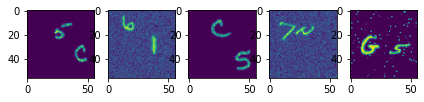

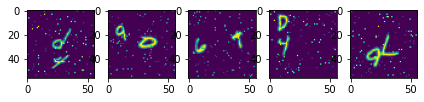

[(5, 'c'), (6, 'i'), (5, 'c'), (7, 'n'), (5, 'g'), (4, 'd'), (9, 'd'), (6, 't'), (4, 't'), (9, 'l')]


In [28]:
img_grid(2, 5, testing_dataset[10000:10010,0])
l1, l2 = multi_net(testing_dataset[10000:10010])
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [30]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = multi_net(testing_dataset[k:k+100])
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [31]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

        # Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000000000100000000000000
2          2  000000000100000000010000000000000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000000000000000000001000000000
14997  14997  000000100000000000000000001000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]
